In [1]:
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import IsolationForest

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import LocalOutlierFactor

from category_encoders import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Helpers

In [2]:
def make_clusters(df, col, y, n_cluster, merge=False):
    '''
        function to boil down a colum to n_cluster
        
        recive:
        
            df: a data frame 
            col: col to make cluster
            y: the response variable
            n_cluster: stamitation of number of cluster
            
        return:  
            a data frame with 'col' droped, and 'col' + '_cluster' column
            is added to the data frame

        
    '''
    col_clusters = KMeans(n_clusters=n_cluster, random_state=777)

    # 'Neighborhood' and 'MSSubClass' stats
    col_stats = df.groupby(col)[y].describe()

    # Getting clusters
    col_clusters.fit(col_stats)

    # preparing DF with cluster lables to merge
    new_name = col + '_Cluster'
    col_cluster_df = pd.DataFrame( { col: col_stats.index.to_list(),
                                     new_name: col_clusters.labels_.tolist()} )
    
    if merge:
        # merging the clusters with the data frame
        df = df.merge(col_cluster_df, how='left', on=col)

        df[new_name] = df[new_name].astype(str)
        
        result = df.drop(columns=col)
        
    else:
        result = col_cluster_df
    
    return result.copy()


# Low frequency categories to 'Other'
def lower_than(df, col, percentage):
    ''' function that will merge low frequency classes into 
        a single class 'Others'

        parameters:
            df: a DataFrame
            col: column's name to work on
            percentage(%): the threshold like 0.1, 0.2

        returns:
            df: the data frame with col's classes that are lowers
                than 'threshold' been repleced with 'Other' category
    '''

    # calculating the column frequency
    col_freq = df[col].value_counts(normalize=True)

    # the getting the column threshold 
    threshold = col_freq.quantile(q= percentage)

    # knowing the classes that are below the threshold
    less_freq_classes = col_freq[ col_freq <= threshold ]

    others = less_freq_classes.index.to_list()

    print(others)

    df[col] = df[col].replace(others, 'Others')

    return df

# Sort correlation matrix without duplicate
def corr_pair(df, cols, threshold = 0.7):
    '''
    function that calculate the corrolation of features
    and filtering just unique pairs 
    '''

    corr = df[cols].corr().abs()

    # creating a matrix same size matrix as 'tr'
    # [1 1 1]
    # [1 1 1]
    # [1 1 1]
    temp_matrix = np.ones(corr.shape)

    # selecting the upper triagle of the matrix
    # excluting the diagonal
    # [0 1 1]
    # [0 0 1]
    # [0 0 0]
    upper_tri = np.triu(temp_matrix, k=1)

    # converting to booleans
    # [FALSE TRUE TRUE]
    # [FALSE FLASE TRUE]
    # [FALSE FALSE FALSE]
    uppper_tri_bool = upper_tri.astype( bool )

    # filterin the corroletion matrix
    upper_corr = corr.where( uppper_tri_bool )

    unique_corr_pair = upper_corr.unstack().dropna()
    sorted_pairs = unique_corr_pair.sort_values(ascending=False)

    return sorted_pairs[ sorted_pairs > threshold ].copy()

### Data

In [3]:
def data(verbose=False):
    
    d_tr = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/train.csv', index_col='Id')
    d_te = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/test.csv', index_col='Id')
    
    # Utilities has just 2 categories, and one of them
    # just appears once so we delete the whole column.
    d_tr = d_tr.drop(columns='Utilities')
    d_te = d_te.drop(columns='Utilities')
    
    # Marking Training Set
    d_tr['Training'] = True
    d_te['Training'] = False  
    
    if(verbose):
        print('d_tr shape:', d_tr.shape)
        print('d_te shape:', d_te.shape)
        
    return (d_tr.copy(), d_te.copy())
    

### Analazy 'Y'('SalePrice')

In [4]:
def analyze_y(df, verbose=False):
    
    
    df = df.copy()
    
    # Plotting
    if(verbose):
        fg, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(11,7))
        # chequing the distribution of 'y' = 'SalePrice'
        
        sns.histplot( df['SalePrice'], bins=50, ax= ax1);
        ax1.title.set_text('Skewed SalePrice')
    
        sns.scatterplot(x=df['GrLivArea'], y=df['SalePrice'], ax=ax3);
        ax3.title.set_text('Outliers')
    
    outliers = df[ df['GrLivArea'] >= 4500].index
    
    # deleting the outliers in 'GrLivArea'
    df.drop(outliers, inplace=True)
    
    # Plotting
    if(verbose):
        # cheking again
        sns.scatterplot(x=df['GrLivArea'], y=df['SalePrice'], ax=ax4);
        ax4.title.set_text('NO Outliers')
    
    # pipeline to scale and do a powerTransforme on y('SalePrice')
    fix_y = Pipeline([('scaler', RobustScaler()), ('power', PowerTransformer(method='yeo-johnson'))])
    
    y = fix_y.fit_transform( df['SalePrice'].values.reshape(-1, 1) )
    
    # Plotting
    if(verbose):
        # checking the distribution of 'y' again
        sns.histplot(y, bins=50, ax=ax2);
        ax2.title.set_text('yeo-johnson transformed \'y\'')
        
        plt.tight_layout()
        plt.show()
        
    # if(verbose):
    print('droped index: \n', outliers)
        
    df['SalePrice'] = y.copy()
    
    return df.copy()
    

### Combining training and test sets

In [5]:
def combine_tr_te(df_tr, df_te, verbose=False):
    
    all_d = pd.concat([d_tr.copy(), d_te.copy()])
    
    if(verbose):
        print('New data shape: ', all_d.shape)
        
    return all_d.copy()

### Imputting 'nan'

In [6]:

def impute_nan(all_data):
    
    # 34 columns with nan
    def fillWithNone(df):
        ''' nan in 'PoolQC' means 'no pool' 
            nan in 'MiscFeature' means 'no misc feature'
            nan in 'Alley' means 'no alley acces'
            nan in 'Fence' means 'no fence'
            nan in 'FireplaceQu' means 'no Fireplace'
            nan in 'GarageType', 'GarageFinish', 'GarageQual',
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1'
                'BsmtFinType1', 'MasVnrType', 'MSSubClass'
                'GarageCond' replaced with 'None' too

            recive a df
        '''

        df = df.copy()

        columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 
                   'FireplaceQu', 'GarageType', 'GarageFinish', 
                   'GarageQual', 'GarageCond', 'BsmtQual',
                   'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                   'BsmtFinType2', 'MasVnrType'
                  ]

        for col in columns:
            df[col] = df[col].fillna('None')

        return df

    def fillWithZero(df):
        ''' nan 

        '''

        df = df.copy()

        columns = ['GarageYrBlt', 'GarageArea', 'GarageCars',
                   'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                   'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                   'MasVnrArea'
                  ]

        for col in columns:
            df[col] = df[col].fillna(0)

        return df

    def fillWithMode(df):
        ''' fill missing values with mode, median
        '''
        df = df.copy()

        columns = ['Electrical', 'KitchenQual', 'Exterior1st',
                   'Exterior2nd', 'SaleType'
                  ]

        for col in columns:
            df[col] = df[col].fillna(df[col].mode()[0])

        # filling with median of each 'Neighborhood'
        df['LotFrontage'] = (
                         df.groupby('Neighborhood')['LotFrontage']
                         .transform(lambda x: x.fillna(x.median()))
                        )  

        # nan means Typical
        df['Functional'] = df['Functional'].fillna('Typ')

        return df


    def mszoning(df):
        ''' recives a DF this imputation takes place on test data only'''

        df = df.copy()

        idotrr = ( (df['Neighborhood'] == 'IDOTRR') & (df['MSZoning'].isna()) )
        mitchel = ( (df['Neighborhood'] == 'Mitchel') & (df['MSZoning'].isna()) )

        df.loc[ idotrr , 'MSZoning'] = 'RM'
        df.loc[ mitchel, 'MSZoning'] = 'RL'

    #     # to test this function out of here
    #     temp = mszoning(d_te)
    #     # lable index acces at [1916, 2217, 2251, 2905
    #     temp.loc[[1916, 2217, 2251, 2905], 'MSZoning']

        return df

    none_func = FunctionTransformer(fillWithNone, validate=False) 
    zero_func = FunctionTransformer(fillWithZero, validate=False) 
    mode_func = FunctionTransformer(fillWithMode, validate=False)
    mszo_func = FunctionTransformer(mszoning, validate=False)
    
    
    imputer = Pipeline([
                    ('withNone', none_func), 
                    ('withZero', zero_func), 
                    ('withMode', mode_func), 
                    ('mszoni', mszo_func)
                   ])
    
    result = imputer.fit_transform(all_data)
    
    return result.copy()

### Reduce Categories(Collapsing)

In [7]:
def reduce_categories(all_data):
    '''
    '''


    con1_others = ['RRAn', 'PosN', 'RRAe', 'PosA', 'RRNn', 'RRNe']
    roofS_others = ['Gambrel', 'Flat', 'Mansard', 'Shed']
    foun_others = ['Slab', 'Stone', 'Wood']
    gara_others = ['None', 'Basment', '2Types', 'CarPort']
    saleT_others = ['ConLD', 'CWD', 'ConLI', 'ConLw', 'Oth', 'Con']
    saleC_others = ['Family', 'Alloca', 'AdjLand']
    exte1_others = ['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc']
    exte2_others = ['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc', 'Other']
    lotC_others = ['FR2', 'FR3']

    all_data['Condition1'] = all_data['Condition1'].map(lambda x: 'Others' if x in con1_others else x)
    all_data['RoofStyle'] = all_data['RoofStyle'].map(lambda x: 'Others' if x in roofS_others else x)
    all_data['Foundation'] = all_data['Foundation'].map(lambda x: 'Others' if x in foun_others else x)
    all_data['GarageType'] = all_data['GarageType'].map(lambda x: 'Others' if x in gara_others else x)
    all_data['SaleType'] = all_data['SaleType'].map(lambda x: 'Others' if x in saleT_others else x)
    all_data['SaleCondition'] = all_data['SaleCondition'].map(lambda x: 'Others' if x in saleC_others else x)
    all_data['Exterior1st'] = all_data['Exterior1st'].map(lambda x: 'Others' if x in exte1_others else x)
    all_data['Exterior2nd'] = all_data['Exterior2nd'].map(lambda x: 'Others' if x in exte2_others else x)
    all_data['LotConfig'] = all_data['LotConfig'].map(lambda x: 'Others' if x in lotC_others else x)


    # Reducing to a BINARY CLASSES(just 2 clases)

    landC_others = ['HLS', 'Bnk', 'Low']
    cond2_others = ['Feedr', 'Artery', 'PosN', 'PosA', 'RRNn', 'RRAn', 'RRAe']
    roofM_others = ['Tar&Grv', 'WdShake', 'WdShngl', 'Metal', 'Membran', 'Roll', 'ClyTile']
    heati_others = ['GasW', 'Grav', 'Wall', 'OthW', 'Floor']
    elect_others = ['FuseA', 'FuseF', 'FuseP', 'Mix']
    miscF_others = ['Shed', 'Gar2', 'Othr', 'TenC']

    all_data['LandContour'] = all_data['LandContour'].map(lambda x: 'Others' if x in landC_others else x)
    all_data['Condition2'] = all_data['Condition2'].map(lambda x: 'Others' if x in cond2_others else x)
    all_data['RoofMatl'] = all_data['RoofMatl'].map(lambda x: 'Others' if x in roofM_others else x)
    all_data['Heating'] = all_data['Heating'].map(lambda x: 'Others' if x in heati_others else x)
    all_data['Electrical'] = all_data['Electrical'].map(lambda x: 'Others' if x in elect_others else x)

    all_data['MiscFeature'] = all_data['MiscFeature'].map(lambda x: 'Others' if x in miscF_others else x)
    
    
    return all_data.copy()

### Features Engineering

In [8]:

def features_engineering(all_data):
    # Before using d_tr set 
    # get the new d_tr set from all_data
    d_tr = all_data[all_data['Training']].copy()

    # Creating a new feature 'PeakMonths', 'Unfinished',
    # 'Splited', and TotalSF
    peak_moS = [5, 6, 7]
    unfi_hou = ['1.5Unf', '2.5Unf']
    spli_hou = ['SFoyer', 'SLvl']

    all_data['PeakMonths'] = all_data['MoSold'].map(lambda x: 'Peak' if x in peak_moS else 'Normal' )
    all_data['Finished']   = all_data['HouseStyle'].map(lambda x: 'no' if x in unfi_hou else 'yes') 
    all_data['Splited']    = all_data['HouseStyle'].map(lambda x: 'yes' if x in spli_hou else 'no')

    all_data['TotalSF']    = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

    
    # ======== Clustering ==========
    # we will use the training data because if we uses all_data
    # it has 'nan' in 'SalePrice'. test data does not have 'SalePrice'
    # 'Neighborhood', 5, 'MSSubClass', 4
    nei_cluster = make_clusters(d_tr.copy(), 'Neighborhood', 'SalePrice', 5)
    mss_cluster = make_clusters(d_tr.copy(), 'MSSubClass', 'SalePrice', 4)

    # merging the clusters data frame with all_data DataFrame
    # we got a 'nan' cluster becouse 'MSSubClass' in test_DF
    # has a '150' class that is just in test
    # we preserved the index from all_d DF
    all_data = all_data.reset_index().merge(nei_cluster, how='left', on='Neighborhood').set_index('Id')
    # all_data.drop(columns='Neighborhood', inplace=True)

    all_data = all_data.reset_index().merge(mss_cluster, how='left', on='MSSubClass').set_index('Id')
    
    # dropping old columns
    # all_data.drop(columns=['Neighborhood', 'MSSubClass'], inplace=True)

    # all_data.reset_index(drop=True, inplace=True)
    
    # ========= Cycling Features ====
    all_data[ 'MoSold' + '_sin'] = np.sin( all_data['MoSold'] * (2.*np.pi/12) )
    all_data[ 'MoSold' + '_cos'] = np.cos( all_data['MoSold'] * (2.*np.pi/12) )
    
    # ========= Cleaning ============
    all_data.drop(columns=['Neighborhood', 'MSSubClass', 'MoSold'], inplace=True)
    
    # updating the ** new feature ** types
    all_data = all_data.astype( {'PeakMonths':str, 'Finished':str, 'Splited':str,
                                 'Neighborhood_Cluster': str, 'MSSubClass_Cluster': str} )#,
                                 # 'MoSold_sin': str, 'MoSold_cos': str } )
    
    return all_data.copy()

# # updating cat_to_1Hot
# cat_to_1Hot.update( {'PeakMonths':str, 'Finished':str, 'Splited':str,
#                        'Neighborhood_Cluster': str, 'MSSubClass_Cluster': str} )

### Global Variables
> ord_cat_mapping  
> cat_to_1Hot  
> ord_cat_DONE  

In [9]:
##### ****** All writed by me ****** #####
##########################################
def get_global_variables():
    ord_cat_mapping = [
        {
            'col': 'FireplaceQu',
            'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        },
        {
            'col': 'GarageQual',
            'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        },
        {
            'col': 'GarageCond',
            'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        },
        {
            'col': 'BsmtFinType1',
            'mapping': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
        },
        {
            'col': 'BsmtFinType2',
            'mapping': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
        },
        {
            'col': 'ExterQual',
            'mapping': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
        },
        {
            'col': 'ExterCond',
            'mapping': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
        },
        {
            'col': 'BsmtQual',
            'mapping': {'None': 0 , 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
        },
        {
            'col': 'BsmtCond',
            'mapping': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4}
        },
        {
            'col': 'PoolQC',
            'mapping': {'None': 0, 'Fa': 1, 'Gd': 2, 'Ex': 3}
        },
        {
            'col': 'HeatingQC',
            'mapping': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
        },
        {
            'col': 'KitchenQual',
            'mapping': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}
        },
        {
            'col': 'BsmtExposure',
            'mapping': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
        },
        {
            'col': 'Functional',
            'mapping': {'Sev': 0, 'Maj2': 1, 'Maj1': 2, 'Mod': 3, 'Min2': 4, 'Min1': 5, 'Typ': 6}
        },
        {
            'col': 'GarageFinish',
            'mapping': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
        },
        {
            'col': 'Fence',
            'mapping': {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
        },
        {
            'col': 'CentralAir',
            'mapping': {'N': 0, 'Y': 1}
        },
        {
            'col': 'PavedDrive',
            'mapping': {'N': 0, 'P': 1, 'Y': 2}
        },
        {
            'col': 'Street',
            'mapping': {'Grvl': 0, 'Pave': 1}
        },
        {
            'col': 'Alley',
            'mapping': {'None': 0, 'Grvl': 1, 'Pave': 2}
        },
        {
            'col': 'LandSlope',
            'mapping': {'Gtl': 0, 'Mod': 1, 'Sev': 2}
        },
        {
            'col': 'LotShape',
            'mapping': {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3}
        },
        {
            'col': 'HouseStyle', 
            'mapping': {'SLvl': 0, 'SFoyer': 0, '1Story': 1, '1.5Fin': 2, 
                        '1.5Unf': 2, '2Story': 3, '2.5Unf': 4, '2.5Fin': 4}
        }
    ]

    # list of categorical columns(23)  
    # that we just encoded
    ord_cat_DONE = {'FireplaceQu': str, 'GarageQual': str,'GarageCond': str,'BsmtFinType1': str,
                     'BsmtFinType2': str,'ExterQual': str,'ExterCond': str,'BsmtQual': str,
                     'BsmtCond': str,'PoolQC': str,'HeatingQC': str,'KitchenQual': str,
                     'BsmtExposure': str,'Functional': str,'GarageFinish': str,'Fence': str, 
                     'CentralAir': str, 'PavedDrive': str,'Street': str,'Alley': str,
                     'LandSlope': str,'LotShape': str, 'HouseStyle': str}

    # to encode using OneHot (15 so far)
    cat_to_1Hot = {'Condition1': str, 'RoofStyle': str, 'Foundation': str, 'GarageType': str, 'SaleType': str, 
                   'SaleCondition': str, 'Exterior1st': str, 'Exterior2nd': str, 'LotConfig': str, 'LandContour': str, 
                   'Condition2': str, 'RoofMatl': str, 'Heating': str, 'Electrical': str, 'MiscFeature': str }

    # updating cat_to_1Hot with new created features
    cat_to_1Hot.update( {'PeakMonths':str, 'Finished':str, 'Splited':str,
                           'Neighborhood_Cluster': str, 'MSSubClass_Cluster': str} )

    # updating the types
    # update the list of ordinal with 2 columns name
    # that allredy are ordinal and encoded ('OverallQual', 'OverallCond')

    ord_cat_DONE.update({'OverallQual': str, 'OverallCond': str})#,
                         # 'MoSold_sin': str, 'MoSold_cos': str})
    # new_d = new_d.astype(ord_cat_DONE)

    # 5 more columns will concidere as categorical
    # we take off 'MoSold': str, 
    cat_to_1Hot.update({'YrSold': str, 'BldgType':str, 
                        'MSZoning': str, 'MasVnrType': str})

    # new_d = new_d.astype(cat_to_1Hot)
    
    # updating the data type
    # df = df.astype(cat_to_1Hot)
    # df = df.astype(ord_cat_DONE)
    
    return (ord_cat_mapping, ord_cat_DONE, cat_to_1Hot)

### Ordinal and OneHot encoding

In [10]:
def ordinal_1hot_encode(all_data, ord_mapping, oneHot_col):
    
    ## OrdinalEncoder
    oe = OrdinalEncoder(mapping=ord_mapping).fit(all_data)
    
    all_data = oe.transform(all_data)
    
    
    ## OneHot encoding
    oh = OneHotEncoder(cols=oneHot_col).fit(all_data)
    
    all_data = oh.transform(all_data.copy())
    
    
    
    return all_data.copy()

### Feature Selection

In [49]:
def feature_selection(X, y, verbose=False, sorted_features=False, random_state=77):
    
    mutual_info = mutual_info_regression(X=X, y=y, random_state=random_state)
    
    mu_info_df = pd.DataFrame(list(zip( X.columns, mutual_info )), columns=['Features', 'Mutual_info'])
    
    feature_to_drop = mu_info_df[ mu_info_df['Mutual_info'] == 0]
    feature_to_drop = list( feature_to_drop['Features'] )
    
    if(verbose):
        #Sorting
        # mu_info_df.sort_values('Mutual_info', ascending=False, inplace=True)
        print('{} Features with Zero(0) mutual info: \n'.format(len(feature_to_drop)))
        feature_to_drop = sorted(feature_to_drop)
        print(feature_to_drop)
        
    if( (verbose == False) and sorted_features):
        feature_to_drop = sorted(feature_to_drop)
        
    
    return (feature_to_drop, mu_info_df.sort_values('Mutual_info', ascending=False).copy() )

### Fix skewed columns

In [33]:
def fix_skew_cols(df, cols, treshold=0.7):
    '''
    this function scals and fix the skewed columns
    by applying RobustScaler() and 'yeo-johnson' transform
    '''
    
    rs = RobustScaler()
    pt = PowerTransformer(method='yeo-johnson')
    
    skewed = all_d[cols].skew()
    
    skewed = skewed[skewed >= treshold] #I changed from 0.7 to treshold
    skewed = skewed.index
    
    print('{} features with skewe >= {}'.format( len(skewed), treshold ) )
    
    # fix_data_skew = Pipeline([('scaler', RobustScaler()), 
    #                       ('yeo', PowerTransformer(method='yeo-johnson'))])
    # df[skewed] = fix_data_skew.fit_transform(df[skewed].copy())
    
    df[cols] = rs.fit_transform(df[cols])
    df[skewed] = pt.fit_transform(df[skewed])
    
    return df.copy()

### Polynomial Features

In [13]:
def poly_features(df, top_cols):
    '''
    function to create the interaction feature of the top_cols
    
    '''
    
    top_cols_set = df[top_cols].copy()
    # top_cols_set
    
    poly_features = PolynomialFeatures(2, interaction_only=True, include_bias=False)
    
    index_backup = top_cols_set.index.copy()
    
    poly_set = pd.DataFrame( poly_features.fit_transform(top_cols_set.copy()), columns=poly_features.get_feature_names_out(top_cols) )
    poly_set.set_index(index_backup, inplace=True)
    # poly_set
    
    poly_set.drop(columns=top_cols, inplace=True)
    # poly_set
    
    result = df.merge(poly_set, left_index=True, right_index=True)
    
    return result.copy()
    

# Driver

### Y

In [14]:
# get the data
d_tr, d_te = data(verbose=True)

d_tr shape: (1460, 80)
d_te shape: (1459, 79)


In [15]:
# taking cara of some outliers
# and making 'y' more gausian like
d_tr = analyze_y(d_tr.copy())

droped index: 
 Int64Index([524, 1299], dtype='int64', name='Id')


In [16]:
# after take care of some outlier
# combine the training and the test
all_d = combine_tr_te(d_tr.copy(), d_te.copy(), verbose=True)
all_d.shape

New data shape:  (2917, 80)


(2917, 80)

### Imputing

In [17]:
# imputing nan
all_d = impute_nan(all_d.copy())

In [18]:
all_d.columns[all_d.isna().any()].to_list()

['SalePrice']

### Reducing Cardinality

In [19]:
# reducing the number of categories in some columns
all_d = reduce_categories(all_d.copy())
# all_d['Foundation'].value_counts()

### Feature Engineering

In [20]:
# Creating a new feature 'PeakMonths', 'Unfinished',
# 'Splited', and TotalSF, and Clusters 
# transforming cyclical feature 'MoSold'
all_d = features_engineering(all_d.copy())

### Identifying  
> Categorical and Number Columns

In [21]:
# getting the global variables
ord_cat_mapping, ord_cat_DONE, cat_to_1Hot = get_global_variables()

In [22]:
# updating the data type
all_d = all_d.astype(cat_to_1Hot)
all_d = all_d.astype(ord_cat_DONE)

In [23]:
# after updating all the categorical columns
# we can now identify the number columns
numbers_col = all_d.select_dtypes('number')
numbers_col = numbers_col.columns.to_list()

# removing the transformed cyclical feature
# that already are float and they were identifyed
# as numerical features and we dont want to
# touch them
numbers_col.remove('MoSold_sin')
numbers_col.remove('MoSold_cos')
# MoSold_sin, MoSold_cos

In [24]:
analyzed_col = numbers_col + list(cat_to_1Hot.keys()) + list(ord_cat_DONE.keys())
set( all_d.columns.to_list() ) - set( analyzed_col )

{'MoSold_cos', 'MoSold_sin', 'Training'}

In [25]:
set( analyzed_col ) - set( all_d.columns.to_list() )

set()

In [27]:
set( analyzed_col ).symmetric_difference( set( all_d.columns.to_list() ) )

{'MoSold_cos', 'MoSold_sin', 'Training'}

In [26]:
print('analyzed_col len:', len(analyzed_col))
print('all_d.columns len', len(all_d.columns.to_list()))

analyzed_col len: 82
all_d.columns len 85


### Fixing skewnnes on Number Columns

In [34]:
# the DF returned will have numbers_col Scalered and 
# PowerTransformed
all_d = fix_skew_cols(all_d.copy(), numbers_col) # this function keeps the index

22 features with skewe >= 0.7


### Doing Ordinal and OneHot Encoding

In [ ]:
# encoding ordinal and onehot columns( keeps Id index)

# ** Warning **
# category_encoders/one_hot.py:145: 
# FutureWarning: iteritems is deprecated and 
# will be removed in a future version. Use .items instead.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

all_d = ordinal_1hot_encode(all_d.copy(), ord_cat_mapping, cat_to_1Hot)

In [ ]:
all_d

### Feature Selection

In [45]:
# getting the training set to work with
d_tr = all_d[ all_d['Training'] ].copy()

In [53]:
# we will get the features that has 0 mutual information with 'y'
# and a DF with **ALL the features** with their mutual info value
# from it we can get the top ones, to do polynomial interaction
to_drop, mutual_info_df = feature_selection( d_tr.drop(columns='SalePrice').copy(), d_tr['SalePrice'].copy()
                                            , verbose=True, sorted_features=True, random_state=70)


31 Features with Zero(0) mutual info: 

['Condition1_1', 'Condition2_1', 'Condition2_2', 'Exterior1st_10', 'Exterior1st_11', 'Exterior1st_5', 'Exterior1st_6', 'Exterior1st_8', 'Exterior1st_9', 'Exterior2nd_12', 'Exterior2nd_3', 'Exterior2nd_9', 'Functional', 'LandSlope', 'LotConfig_2', 'LotConfig_3', 'LowQualFinSF', 'MSSubClass_Cluster_2', 'MiscVal', 'MoSold_sin', 'Neighborhood_Cluster_2', 'PeakMonths_2', 'PoolArea', 'RoofMatl_2', 'RoofStyle_3', 'SaleCondition_4', 'SaleType_4', 'Street', 'Training', 'YrSold_3', 'YrSold_5']


### Polynomial and Interaction Features

In [54]:
# from mutual_info_df get the top 20 features
# that has the hight mutual information
# becouse it is ordered we can take the top 20
top_20_cols = mutual_info_df.head(20)['Features'].to_list()
print( top_20_cols )

['TotalSF', 'OverallQual', 'GrLivArea', 'GarageArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt', 'KitchenQual', 'BsmtQual', 'ExterQual', '1stFlrSF', 'GarageFinish', 'FullBath', 'GarageYrBlt', 'YearRemodAdd', 'TotRmsAbvGrd', 'FireplaceQu', 'LotFrontage', '2ndFlrSF', 'LotArea']


In [55]:
all_d.shape

(2917, 158)

In [56]:
# we will get the interaction factor por the top 20 
all_d = poly_features(all_d.copy(), top_20_cols)

In [57]:
all_d.shape

(2917, 348)

> Before modeling drop the features with 0 mutual info  
> beacous the list has 'Training'

In [58]:
# we keep 'Training' column to identify training set in all_d
to_drop.remove('Training')

In [59]:
# aditional features that we dont 
# want to remove
to_drop.remove('MoSold_sin')

In [60]:
all_d.shape, len(to_drop)

((2917, 348), 29)

In [61]:
# 'Training' is in to_drop list
all_d.drop(columns=to_drop, inplace=True)

In [62]:
all_d.shape

(2917, 319)

> Getting **the Training, Test set** and 'y' back

In [63]:
tr = all_d[ all_d['Training'] ].copy()
te = all_d[  ~all_d['Training'] ].copy()

In [64]:
y = tr[ 'SalePrice' ].copy()

tr.drop(columns='SalePrice', inplace=True)
te.drop(columns='SalePrice', inplace=True)

### Outliers detection

> Using **IsolationForest**

In [65]:
iso_forest = IsolationForest()

In [66]:
y_hat = iso_forest.fit_predict(tr)

In [67]:
inliers_mask = y_hat != -1

In [68]:
print( 'There are {} outliers'.format(np.count_nonzero(y_hat == -1)))

There are 108 outliers


In [69]:
# reshape to print the indexes in a block
print(np.argwhere(y_hat == -1).reshape(1,-1))

[[  11   39   48   53   58   78   88  113  125  127  155  163  178  185
   197  198  224  268  278  291  304  313  324  349  362  375  378  386
   389  393  417  434  440  441  473  477  489  490  495  496  515  520
   526  528  532  534  580  581  582  590  613  619  634  635  637  648
   663  690  704  709  746  768  783  797  802  824  825  842  897  915
   920  933  941  953  967  975 1010 1023 1029 1037 1038 1045 1095 1099
  1122 1141 1168 1172 1178 1181 1217 1218 1227 1233 1256 1265 1266 1267
  1282 1319 1321 1323 1324 1335 1347 1371 1435 1447]]


> Removing outliers

In [70]:
tr.shape

(1458, 318)

In [71]:
tr = tr.iloc[inliers_mask, : ]
y  = y[inliers_mask]

In [72]:
tr.shape

(1350, 318)

> using **residuals**

In [73]:
lr = LinearRegression()

In [74]:
lr.fit(tr, y)

LinearRegression()

In [75]:
y_hat = lr.predict(tr)

In [76]:
residuals = y - y_hat
standard_residuals = abs(  ( residuals - residuals.mean() ) / residuals.std() )

In [77]:
inliers_mask = standard_residuals <= 3

In [78]:
print( 'there are {} new outliers'.format( np.count_nonzero( (standard_residuals >= 3) ) ))

there are 14 new outliers


In [79]:
# index dropped
inliers_mask[ inliers_mask == False].index

Int64Index([143, 329, 411, 463, 561, 629, 633, 663, 682, 689, 715, 775, 1325,
            1433],
           dtype='int64', name='Id')

> **removing** new outliers

In [80]:
tr.shape

(1350, 318)

In [81]:
tr = tr.loc[ inliers_mask ]

In [82]:
y = y[ inliers_mask ]

In [83]:
tr.shape, y.shape

((1336, 318), (1336,))

### Saving training and test data

In [84]:
tr.to_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/tr.csv', index=True)
te.to_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/te.csv', index=True)
y.to_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/y.csv', index=True)

# Modeling

In [1]:
from sklearn.linear_model import TheilSenRegressor, HuberRegressor, RANSACRegressor, Ridge
from sklearn.linear_model import ElasticNet, ElasticNetCV
from xgboost import XGBRegressor
import catboost as cb

from sklearn.ensemble import StackingRegressor

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tr = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/tr.csv', index_col='Id')
te = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/te.csv', index_col='Id')
y = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/y.csv', index_col='Id')

y = y.to_numpy(dtype='float64').reshape(-1,)

In [3]:
X_tr, X_te, y_tr, y_te = train_test_split(tr, y, test_size=0.20, random_state=77)

> **TheilSenRegressor()**

In [4]:
# main paramater to change n_subsamples 
# , max_subpopulation
theheil_params = {'max_iter':500
                  ,'tol':0.01
                  ,'max_subpopulation':1000.0
                  ,'n_subsamples':500 # < 843(samples in this data set)
                  ,'random_state':77
                  ,'n_jobs':-1}

theheil = TheilSenRegressor(**theheil_params)

scores = cross_validate(theheil, X_tr, y_tr, cv=5, n_jobs=-1, scoring='neg_mean_squared_error' )

theheil.fit(X_tr, y_tr)

te_score = mean_squared_error(y_te, theheil.predict(X_te))

print('fit time:{}, tr score: {}, test score:{}'.format(scores['fit_time'].sum()
                                                        , scores['test_score'].mean(), te_score))

# best score with this configuration
# fit time:26.734277963638306, tr score: -0.46514573931232694, test score:0.07519757919341458
# max_iter=500
# ,max_subpopulation=5000.0
# ,tol=0.1
# ,n_subsamples=843 <-***** I changed this the last and I got an improvesment and faster

fit time:462.46298933029175, tr score: -0.2223834035546747, test score:0.06056392209930399


> **HuberRegressor()**

In [14]:
huber_params = {'alpha': 0.001 #default=0.0001
                ,'epsilon': 1.135 # must be >= 1 the number of samples consider outliers
                ,'max_iter': 1000 #default=100
                ,'tol': 0.00001 #default=1e-05
                }

huber = HuberRegressor(**huber_params)

scores = cross_validate(huber, X_tr, y_tr, cv=5, n_jobs=-1, scoring='neg_mean_squared_error' )

huber.fit(X_tr, y_tr)

te_score = mean_squared_error(y_te, huber.predict(X_te))

print('fit time:{}, tr score: {}, test score:{}'.format(scores['fit_time'].sum()
                                                        , scores['test_score'].mean(), te_score))

# Best score using this configuration 'alpha': 0.001, epsilon=1.135, 'max_iter': 1000, 'tol': 0.00001
# fit time:20.546488046646118, tr score: -0.06613938128838738, test score:0.04605998760380083


fit time:20.546488046646118, tr score: -0.06613938128838738, test score:0.04605998760380083


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


> **RANSACRegressor**

In [128]:
# # median absolute deviation(MAD) is the same for
# MAD = np.median( np.absolute( y_tr - np.median(y_tr) ) )
# MAD = 0.6013 

# Note: when I used residual_threshold = None(defoul) it got slower
# than when I used the MAD*2 for cut off outliers and got the same result

ransac_params = {'max_trials':50 
                 ,'min_samples':739 # must be < 844 (samples in the data set)
                 ,'residual_threshold':0.601 #1.2 #0.6013 # residual_threshold = MAD = None #Default to NONE
                 ,'random_state':77}

ransac = RANSACRegressor(**ransac_params)

scores = cross_validate(ransac, X_tr, y_tr, cv=5, n_jobs=-1, scoring='neg_mean_squared_error' )

ransac.fit(X_tr, y_tr)

te_score = mean_squared_error(y_te, ransac.predict(X_te))

print('fit time:{}, tr score: {}, test score:{}'.format(scores['fit_time'].sum()
                                                        , scores['test_score'].mean(), te_score))

# best score
# 'max_trials':50, 'min_samples':739, 'residual_threshold':0.601
# fit time:2.15836501121521, tr score: -41618040098332.74, test score:0.05661176271476029

fit time:2.210031032562256, tr score: -41618040098332.74, test score:0.05661176271476029


> **Ridge**

In [130]:
#########******###########
# Note: after the gridsearch this was the final model

ridge_params = {'alpha': 4.5
               ,'max_iter':500#None
               ,'tol':0.001
               ,'solver':'auto'#,positive=True
               ,'random_state':77}

ridge = Ridge(**ridge_params)


scores = cross_validate(ridge, X_tr, y_tr, cv=5, n_jobs=-1, scoring='neg_mean_squared_error' )

ridge.fit(X_tr, y_tr)

te_score = mean_squared_error(y_te, ridge.predict(X_te))

print('fit time:{}, tr score: {}, test score:{}'.format(scores['fit_time'].sum()
                                                        , scores['test_score'].mean(), te_score))


# fit time:0.21917223930358887, tr score: -0.05613145180557899, test score:0.0498831474217563
# alpha 4.5



fit time:0.21917223930358887, tr score: -0.05613145180557899, test score:0.0498831474217563


In [27]:
#########******###########
#this was just to do the gridsearch on Ridge()

ridge = Ridge(random_state=77)

ridge_param = {'alpha': np.arange(1.18, 1.21, 0.001) }
               # ,'max_iter': None
               # ,'tol':0.001
               # ,'solver': 'auto'}

gs_ridge = GridSearchCV(ridge, param_grid=ridge_param, cv=5, refit=True
                        , scoring='neg_mean_squared_error', n_jobs=-1)

%timeit gs_ridge.fit(X_tr, y_tr)


te_score = mean_squared_error(y_te, gs_ridge.predict(X_te))

print('\ntest score:{}  \nbest training score:{}'.format( te_score, gs_ridge.best_score_))
print('Best params: {}'.format(gs_ridge.best_params_))

895 ms ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

test score:0.06305865413794026  
best training score:-0.3207073358290147
Best params: {'alpha': 1.18}


In [25]:
np.arange(1.18, 1.21, 0.001)

array([1.18 , 1.181, 1.182, 1.183, 1.184, 1.185, 1.186, 1.187, 1.188,
       1.189, 1.19 , 1.191, 1.192, 1.193, 1.194, 1.195, 1.196, 1.197,
       1.198, 1.199, 1.2  , 1.201, 1.202, 1.203, 1.204, 1.205, 1.206,
       1.207, 1.208, 1.209, 1.21 ])

> **ElasticNet**

In [ ]:
#########******###########
# Note: this was just to do the 
# gridsearch on ElasticNet()

# total of inter=900
grid = {'l1_ratio': np.arange(0, 1, 0.01)
        ,'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0]}

e_net = ElasticNet()

rs = RandomizedSearchCV(e_net, param_distributions=grid, cv=5, n_iter=100, refit=True
                        , scoring='neg_mean_squared_error', n_jobs=-1, random_state=77)

%timeit rs.fit(X_tr, y_tr)

# best params
# 'l1_ratio': 0.99, 'alpha': 0.001
#score -0.06356975787949057

In [116]:
#########******###########
# Note: after the gridsearch this was the final model
# The parameter 'l1_ratio' -> 'alpha' in the glmnet R package while
# 'alpha' -> 'lambda' parameter in glmnet. comom 0.001

e_net_params = {'alpha':0.001 #  'alpha' weighting of the sum of both penalties #Defaults to 1.0.
                ,'l1_ratio':0.99
                ,'max_iter':25000 #10000 default=1000
                ,'tol':0.03 #default=0.0001
                ,'random_state':77
                }

e_net = ElasticNet(**e_net_params)

e_net.fit(X_tr, y_tr)

te_score = mean_squared_error(y_te, e_net.predict(X_te))

print('test score:{}'.format(te_score))

# alpha=0.001 and l1_ratio=0.99
# test score:0.0555403982105972

test score:0.0555093443389372


> **XGBOOST**

In [56]:
evalset = [(X_tr, y_tr), (X_te, y_te)]

In [58]:
xgb_params = {'n_estimators': 1475 #[100,200,500]
          ,'learning_rate': 0.07 # defaul=0.3 range: [0,1] typical: 0.01-0.02
          ,'max_depth': 3 #defaul=6 range: [0,∞] typical 3-10
          ,'min_child_weight': 2 #defaul=1 range: [0,∞] higher good, too hight underfit
          # ,'sampling_method': 'uniform' #defaul=uniform [uniform, gradient_based]
          ,'subsample': 0.7 #defaul=1 range: (0,1] typical 0.5 - 1
          ,'colsample_bytree': 1 #defaul=1 range: (0,1]
          # ,'colsample_bylevel': 1 #defaul=1 range: (0,1]
          # ,'colsample_bynode': 1 #defaul=1 range: (0,1]
          ,'eval_metric': mean_squared_error #set by the xgboost acord to 'objective'
          # ,'objective': 'reg:squarederror' #default = 'reg:squarederror'
          # ,'gamma': 0 #defaul=0 range: [0,∞] the larger the more conservative the algorithm will be
          ,'n_jobs': -1
          ,'random_state': 77
          }

xgb_model = XGBRegressor(**xgb_params)

xgb_model.fit(X_tr, y_tr 
        ,eval_set=evalset
        # ,eval_metric='rmse'
        ,verbose=False )

te_score = mean_squared_error(y_te, xgb_model.predict(X_te))

print('test score:{}'.format(te_score))

test score:0.06582539503928103


In [84]:
params.update({'Test_score': te_score})
# scores_df = pd.DataFrame([xgb_params])
scores_df = pd.concat([scores_df, pd.DataFrame([xgb_params])], ignore_index=True)
scores_df

,n_estimators,learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,eval_metric,n_jobs,random_state,Test_score
0,300,0.07,6,1,1.0,1,<function mean_squared_error at 0x7fb5651df430>,-1,77,0.080802
1,300,0.07,4,2,0.7,1,<function mean_squared_error at 0x7fb5651df430>,-1,77,0.066194
2,2000,0.07,3,2,0.7,1,<function mean_squared_error at 0x7fb5651df430>,-1,77,0.066053
3,1500,0.07,3,2,0.7,1,<function mean_squared_error at 0x7fb5651df430>,-1,77,0.065842
4,1455,0.07,3,2,0.7,1,<function mean_squared_error at 0x7fb5651df430>,-1,77,0.065824


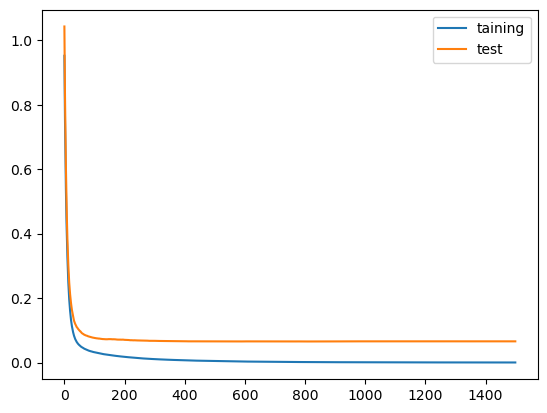

In [75]:
to_plot = xgb_model.evals_result()

plt.plot(to_plot['validation_0']['mean_squared_error'], label='taining')
plt.plot(to_plot['validation_1']['mean_squared_error'], label='test')

plt.legend()
plt.show()

> **CatBoostRegressor**

In [66]:
tr_pool = cb.Pool(X_tr, y_tr)
te_pool = cb.Pool(X_te, y_te)

/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [73]:
cb_params = {
             # 'iterations':700
             'n_estimators':15000
             ,'learning_rate':0.005
             ,'depth':2
             ,'l2_leaf_reg':20
             ,'loss_function':'RMSE'
             ,'subsample':0.3
             ,'colsample_bylevel':0.3
             ,'random_state':77
             ,'verbose':False
             ,'use_best_model': False #True to not save trees after iterations
             # ,'early_stopping_rounds':200 #after 200 iteractions without improvement stop
             # ,'verbose':False #200 output info every 200 iterations
             # ,'task_type':"GPU" # research for more of this option
             }

cb_model = cb.CatBoostRegressor(**cb_params)

cb_model.fit(tr_pool, eval_set=te_pool, verbose=False)

te_score = mean_squared_error(y_te, cb_model.predict(te_pool))

print('test score:{}'.format(te_score))
#test score:0.06626215026710654

test score:0.06626487914745764


> **StackingRegressor**

In [ ]:
theheil = TheilSenRegressor(**theheil_params)
huber = HuberRegressor(**huber_params)
ransac = RANSACRegressor(**ransac_params)
ridge = Ridge(**ridge_params)
e_net = ElasticNet(**e_net_params)
xgb_model = XGBRegressor(**xgb_params)


cb_model = cb.CatBoostRegressor(**cb_params)

In [62]:
from sklearn.ensemble import StackingRegressor

In [117]:
# level0 = [ ('theheil', TheilSenRegressor(**theheil_params))
#           ,('huber', HuberRegressor(**huber_params))
#           ,('ransac', RANSACRegressor(**ransac_params))
#           ,('ridge', Ridge(**ridge_params))
#           ,('e_net', ElasticNet(**e_net_params))
#           ,('xgb_model', XGBRegressor(**xgb_params))
#           ]

level0 = [ 
          ('theheil', theheil)
          ,('e_net', e_net)
          ,('huber', huber)
          ,('ransac', ransac)
          ,('ridge', ridge) # to this point no error
          ,('xgb_model', xgb_model)
          ]

level1 = cb_model


# level1 = cb.CatBoostRegressor(**cb_params)

final_model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5
                                , passthrough=False, n_jobs=-1, verbose=False)

final_model.fit(X_tr, y_tr)

stacking_score = mean_squared_error(y_te, final_model.predict(X_te))

print('staking test score: {}'.format(stacking_score))

staking test score: 0.05438936139901725


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [80]:
print()

In [143]:
d_tr.loc[965:975, 'Training']

Id
965    True
966    True
967    True
968    True
970    True
972    True
973    True
974    True
975    True
Name: Training, dtype: bool

In [63]:
y.loc[965:975]

Id
965    0.685044
966    0.237180
967   -0.056528
968   -0.533016
970   -0.429583
972    0.150980
973   -1.381308
974    0.280746
975    0.066367
Name: SalePrice, dtype: float64

In [64]:
y.tail(7)

Id
1453   -0.330188
1455    0.321856
1456    0.180704
1457    0.630526
1458    1.175759
1459   -0.386845
1460   -0.282014
Name: SalePrice, dtype: float64

# investigate

In [132]:
tr.iloc[:7,140:160].describe().loc[['mean', 'min', 'max']]

,TotalSF YearRemodAdd,TotalSF TotRmsAbvGrd,TotalSF LotFrontage,TotalSF FireplaceQu,TotalSF 2ndFlrSF,TotalSF LotArea,OverallQual GrLivArea,OverallQual GarageCars,OverallQual GarageArea,OverallQual TotalBsmtSF,OverallQual YearBuilt,OverallQual KitchenQual,OverallQual BsmtQual,OverallQual ExterQual,OverallQual 1stFlrSF,OverallQual GarageFinish,OverallQual GarageYrBlt,OverallQual FullBath,OverallQual YearRemodAdd,OverallQual TotRmsAbvGrd
mean,675.453749,0.370197,0.118897,1.284191,0.106477,0.153700,3.651321,15.857143,4217.428571,7417.714286,13612.285714,12.142857,20.714286,11.142857,-0.432907,12.0,13695.285714,12.0,13670.857143,2.706672
min,-838.526928,-0.061512,-0.326119,-0.000000,-0.926026,-0.397231,-2.281518,10.000000,2400.000000,3980.000000,9965.000000,5.000000,14.000000,5.000000,-5.602390,5.0,9965.000000,5.0,9975.000000,-4.785953
max,2183.302259,1.587972,0.770762,4.355715,1.479712,1.014341,10.761763,24.000000,6688.000000,13488.000000,16032.000000,16.000000,32.000000,16.000000,10.685698,16.0,16032.000000,16.0,16040.000000,12.084896


In [ ]:
no one hot encode
YearBuilt	YearRemodAdd
GarageYrBlt 

scaler
-GarageArea
-TotalSF GarageArea
-TotalSF TotalBsmtSF
TotalSF YearBuilt
TotalSF GarageYrBlt
TotalSF YearRemodAdd
OverallQual GarageArea

In [134]:
otras = ['TotalSF', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'KitchenQual'
         , 'BsmtQual', 'ExterQual', '1stFlrSF', 'GarageFinish', 'GarageYrBlt', 'FullBath', 'YearRemodAdd', 'TotRmsAbvGrd'
         , 'LotFrontage', 'FireplaceQu', '2ndFlrSF', 'LotArea']
tr[otras].describe().loc[['mean', 'min', 'max']]

,TotalSF,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,YearBuilt,KitchenQual,BsmtQual,ExterQual,1stFlrSF,GarageFinish,GarageYrBlt,FullBath,YearRemodAdd,TotRmsAbvGrd,LotFrontage,FireplaceQu,2ndFlrSF,LotArea
mean,-0.046516,6.0,-0.047351,1.742033,463.37481,1025.932473,1970.486343,1.468892,2.469651,1.355842,-0.031355,1.693475,1887.405159,1.53566,1984.20258,-0.009038,0.022200,1.735205,-0.010592,0.021108
min,-3.122578,2.0,-3.097031,0.000000,0.00000,0.000000,1872.000000,0.000000,0.000000,0.000000,-2.692153,0.000000,0.000000,0.00000,1950.00000,-2.857732,-2.668826,0.000000,-0.850401,-2.832824
max,2.375943,10.0,2.164073,4.000000,1248.00000,3206.000000,2009.000000,3.000000,4.000000,3.000000,2.141641,3.000000,2010.000000,3.00000,2010.00000,2.784633,4.254307,5.000000,1.654287,6.419474


In [ ]:
analyzed_col = numbers_col + list(cat_to_1Hot.keys()) + list(ord_cat_DONE.keys())
set( all_d.columns.to_list() ) - set( analyzed_col )

In [29]:
print(numbers_col)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'TotalSF']


In [30]:
print(list(cat_to_1Hot.keys()))

['Condition1', 'RoofStyle', 'Foundation', 'GarageType', 'SaleType', 'SaleCondition', 'Exterior1st', 'Exterior2nd', 'LotConfig', 'LandContour', 'Condition2', 'RoofMatl', 'Heating', 'Electrical', 'MiscFeature', 'PeakMonths', 'Finished', 'Splited', 'Neighborhood_Cluster', 'MSSubClass_Cluster', 'YrSold', 'BldgType', 'MSZoning', 'MasVnrType']


In [32]:
print( list(ord_cat_DONE.keys() ) )

['FireplaceQu', 'GarageQual', 'GarageCond', 'BsmtFinType1', 'BsmtFinType2', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'PoolQC', 'HeatingQC', 'KitchenQual', 'BsmtExposure', 'Functional', 'GarageFinish', 'Fence', 'CentralAir', 'PavedDrive', 'Street', 'Alley', 'LandSlope', 'LotShape', 'HouseStyle', 'OverallQual', 'OverallCond']


In [43]:
all_d.shape

(2917, 158)

In [42]:
all_d.iloc[:7,0:20].describe()#.loc[['mean', 'min', 'max']]

,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,MSZoning_5,LotFrontage,LotArea,Street,Alley,LotShape,LandContour_1,LandContour_2,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope,Condition1_1,Condition1_2,Condition1_3
count,7.0,7.0,7.0,7.0,7.0,7.000000,7.000000,7.0,7.0,7.000000,7.0,7.0,7.000000,7.000000,7.000000,7.0,7.0,7.000000,7.000000,7.0
mean,1.0,0.0,0.0,0.0,0.0,0.265968,0.407040,1.0,0.0,0.571429,1.0,0.0,0.571429,0.285714,0.142857,0.0,0.0,0.857143,0.142857,0.0
std,0.0,0.0,0.0,0.0,0.0,0.456940,0.417178,0.0,0.0,0.534522,0.0,0.0,0.534522,0.487950,0.377964,0.0,0.0,0.377964,0.377964,0.0
min,1.0,0.0,0.0,0.0,0.0,-0.401931,-0.129385,1.0,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
25%,1.0,0.0,0.0,0.0,0.0,-0.070275,0.153893,1.0,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
50%,1.0,0.0,0.0,0.0,0.0,0.335483,0.266200,1.0,0.0,1.000000,1.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0
75%,1.0,0.0,0.0,0.0,0.0,0.646442,0.719875,1.0,0.0,1.000000,1.0,0.0,1.000000,0.500000,0.000000,0.0,0.0,1.000000,0.000000,0.0
max,1.0,0.0,0.0,0.0,0.0,0.775893,0.964926,1.0,0.0,1.000000,1.0,0.0,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0.0


In [37]:
all_d.head(7)

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,...,SalePrice,Training,PeakMonths,Finished,Splited,TotalSF,Neighborhood_Cluster,MSSubClass_Cluster,MoSold_sin,MoSold_cos
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,-0.144838,-0.129385,Pave,None,Reg,Lvl,Inside,Gtl,Norm,...,0.470486,True,Normal,yes,no,0.160764,3,2.0,8.660254e-01,5.000000e-01
2,RL,0.559671,0.159636,Pave,None,Reg,Lvl,Others,Gtl,Feedr,...,0.212607,True,Peak,yes,no,0.105517,1,1.0,5.000000e-01,-8.660254e-01
3,RL,0.004287,0.494669,Pave,None,IR1,Lvl,Inside,Gtl,Norm,...,0.594466,True,Normal,yes,no,0.338370,3,2.0,-1.000000e+00,-1.836970e-16
4,RL,-0.401931,0.148149,Pave,None,IR1,Lvl,Corner,Gtl,Norm,...,-0.321365,True,Normal,yes,no,0.037081,4,3.0,8.660254e-01,5.000000e-01
5,RL,0.733213,0.964926,Pave,None,IR1,Lvl,Others,Gtl,Norm,...,0.788902,True,Normal,yes,no,1.051211,4,2.0,-2.449294e-16,1.000000e+00
6,RL,0.775893,0.945081,Pave,None,IR1,Lvl,Inside,Gtl,Norm,...,-0.275722,True,Normal,yes,no,-0.420314,4,3.0,-8.660254e-01,5.000000e-01
7,RL,0.335483,0.266200,Pave,None,Reg,Lvl,Inside,Gtl,Norm,...,1.132490,True,Normal,yes,no,1.088929,0,1.0,-8.660254e-01,-5.000000e-01
